# Análise de preços das ações das empresas AMD, ASUS, Intel, MSI, NVIDIA

---


Vamos analisar os DataFrames das seguintes empresas: AMD, ASUS, INTEL, MSI, NVIDIA. Ver o comportamento delas ao longo dos anos. 

As colunas do DataFrames estão organizadas da seguinte forma:

* Date: Data (AAAA-MM-DD)

* Open: O valor que a ação abriu o dia

* High: O maior valor que ela atingiu no dia

* Low: O menor valor que ela atingiiu no dia

* Close: O valor que a ação fechou o dia

* Adj Close: "Adjusted Close" preço de fechamento ajustado.

* Volume: Volume de ações negociadas.

In [93]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import datetime
from prophet import Prophet
from pandas.tseries.offsets import BDay
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import train_test_split


%matplotlib inline 

amd = pd.read_csv("AMD (1980-2023).csv", parse_dates=['Date'])
asus = pd.read_csv("ASUS (2000-2023).csv", parse_dates=['Date'])
intel = pd.read_csv("Intel (1980-2023).csv", parse_dates=['Date'])
msi = pd.read_csv("MSI (1962-2023).csv", parse_dates=['Date'])
nvidia = pd.read_csv("NVIDIA (1999-2023).csv", parse_dates=['Date'])

In [91]:
def filter_df(df, start_date, end_date):
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    df_filtered = df[(df.Date >= start_date) & (df.Date <= end_date)]
    return df_filtered

In [ ]:
nvidia.info()

In [3]:
# Definindo o intervalo de tempo nos dataframes 2000 - 2023
start_date = '2000-01-01'
end_date = '2023-04-17'

df_list = [amd, asus, intel, msi, nvidia]

df_list_filtered = []

for df in df_list:
    df_filtered = filter_df(df, start_date, end_date)
    df_list_filtered.append(df_filtered)

amd_2000, asus_2000, intel_2000, msi_2000, nvidia_2000 = df_list_filtered


[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Price Close'),
 Text(0.5, 1.0, 'Movimet Stock Price (2000-2023)')]

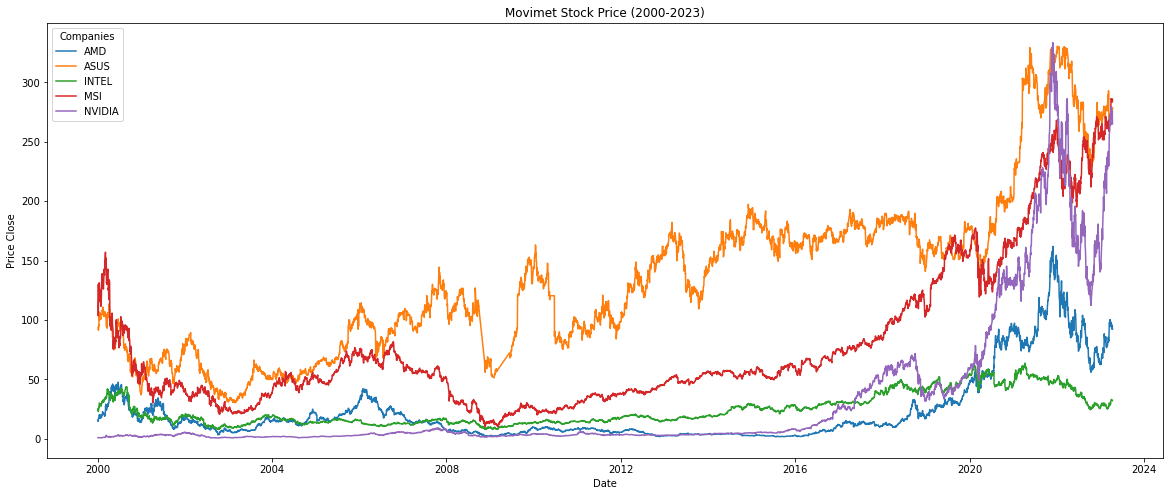

In [10]:
# price plot
labels = ['AMD', 'ASUS', 'INTEL', 'MSI', 'NVIDIA']
fig, ax = plt.subplots(figsize=(20,8))
for i,df in enumerate(df_list_filtered):
    sns.lineplot(data=df, x="Date", y="Adj Close", label=labels[i])

ax.legend(title="Companies")
ax.set(xlabel='Date', ylabel='Price Close', title='Movimet Stock Price (2000-2023)')

>Aqui podemos observar que a ASUS sempre esteve em alta ao longo dos anos e em 2020 ela caiu como a maioria das empresas, provavelmente por conta da pandemia do COVID-19.

>Podemos notar também que a empresa MSI teve grande evolução a partir de 2016 e se encontra hoje entre as com maior valor de ação.

>A empresa NVIDIA se desenvolveu muito no período de pandemia e assumindo o lugar entre as 3 com maior valor de ação.

In [49]:
nvidia_2020 = filter_df(nvidia, '2022-01-01', '2023-04-17')


In [ ]:
# volume plot x price NVIDIA
fig, ax1 = plt.subplots(figsize=(20,8))

sns.barplot(data=nvidia_2020, x="Month", y="Volume", ax=ax1)
ax1.set_ylabel('Volume')


ax2 = ax1.twinx()
sns.lineplot(data=nvidia_2020, x="Month", y="Adj Close", color='b', ax=ax2, alpha=0.5)
ax2.set_ylabel('Adj Close')


ax2.set(xlabel='Date', title='Volume NVIDIA (2021-2023)')
plt.xticks(rotation = 45)

In [98]:
def draw_plot(data,start_date: str, end_date: str, dataset_name: str):
    from plotly.subplots import make_subplots


    df = filter_df(data, start_date, end_date)
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    #fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['Date'], y=df['Adj Close'], name='Price'), secondary_y=False)
    fig.add_trace(go.Bar(x=df['Date'], y=df['Volume'], name='Volume'), secondary_y=True)

    fig.update_layout(title=f'Price and Volume Variation of {dataset_name} Stock from {start_date[:4]} to {end_date[:4]}',
                   xaxis_title='Date',
                   yaxis_title='Price')
    fig.update_yaxes(title='Volume', secondary_y=True)
    
    return fig.show()

In [99]:
# NVIDIA
draw_plot(nvidia, '2022-11-01', '2023-04-17', 'NVIDIA')

In [100]:
# AMD
draw_plot(amd, '2022-11-01', '2023-04-17', 'AMD')

In [101]:
draw_plot(asus, '2022-11-01', '2023-04-17', 'ASUS')

In [102]:
draw_plot(msi, '2022-11-01', '2023-04-17', 'MSI')

In [103]:
draw_plot(intel, '2022-11-01', '2023-04-17', 'INTEL')

In [ ]:
forecast

In [92]:
# prediction with matplot
def prediction(df, days: int):
    data = df[["Date", "Adj Close"]]
    data.ta.ema(close='Adj Close', length=21, append=True)
    data.dropna(inplace=True)

    # criando o dataset train
    df_train = data[["Date", "Adj Close", "EMA_21"]]
    df_train = df_train.rename(columns={"Date":"ds", "Adj Close":"y"})

    # fit model que iremos utilizar
    model = Prophet(daily_seasonality=True)

    # train model
    model.fit(df_train)

    n_days = days

    # create a date range
    future_dates = pd.date_range(start=df_train['ds'].max(), periods=n_days, freq=BDay())

    # create DF with the future dates
    future = pd.DataFrame({'ds': future_dates})

    # filter DF to keep week days
    future = future[future['ds'].dt.dayofweek < 5]

    future = model.make_future_dataframe(periods=30)

    predict = model.predict(future)

    # plot 
    plt.subplots(figsize=(20,8))

    # Plot real values and predicted values
    plt.plot(df_train['ds'], df_train['y'], label='Real Value')
    plt.plot(predict['ds'], predict['yhat'], label='Predicted Value')
    plt.plot(predict['ds'], predict['yhat_upper'], label='Predicted Value UP')
    plt.plot(predict['ds'], predict['yhat_lower'], label='Predicted Value LOWER')
    # Set x-label and y-label
    plt.xlabel('Date')
    plt.ylabel('Price')

    # Set title
    plt.title('Real vs Predicted Value of the Stock')

    # Show legend
    plt.legend()

    # Cross Validation
    df_cv = cross_validation(model, initial='180 days', period='45 days', horizon = '90 days')

    df_p = performance_metrics(df_cv)
    
    print(f'Cross Validation:\n', df_cv.head())

    print(f'Perfomace Metrics:\n{df_p.head()}')

    
    fig = plot_cross_validation_metric(df_cv, metric='mape')


    return plt.show()

    





C:\Users\jeanm\AppData\Local\Temp\ipykernel_8664\3744601756.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.ta.ema(close='Adj Close', length=21, append=True)
C:\Users\jeanm\AppData\Local\Temp\ipykernel_8664\3744601756.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
11:12:03 - cmdstanpy - INFO - Chain [1] start processing
11:12:03 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:12:04 - cmdstanpy - INFO - Chain [1] start processing
11:12:04 - cmdstanpy - INFO - Chain [1] done processing
 

Cross Validation:
           ds       yhat  yhat_lower  yhat_upper          y     cutoff
0 2022-08-31  96.729689   87.241922  105.751902  84.870003 2022-08-30
1 2022-09-01  96.509198   88.576917  106.478510  82.330002 2022-08-30
2 2022-09-02  96.437141   87.029744  105.487614  80.239998 2022-08-30
3 2022-09-06  96.854428   87.321748  106.353174  78.720001 2022-08-30
4 2022-09-07  98.011485   88.802321  107.415190  79.610001 2022-08-30
Perfomace Metrics:
  horizon         mse       rmse        mae      mape     mdape     smape  \
0 10 days  134.007908  11.576178  10.136460  0.135577  0.154662  0.137434   
1 11 days  120.861159  10.993687   9.502472  0.129019  0.143845  0.131391   
2 12 days  110.436601  10.508882   8.983606  0.122413  0.143845  0.125152   
3 13 days  105.714427  10.281752   8.767495  0.118317  0.143845  0.120192   
4 14 days  132.245328  11.499797   9.967002  0.133302  0.154126  0.134957   

   coverage  
0  0.555556  
1  0.625000  
2  0.638889  
3  0.666667  
4  0.5416

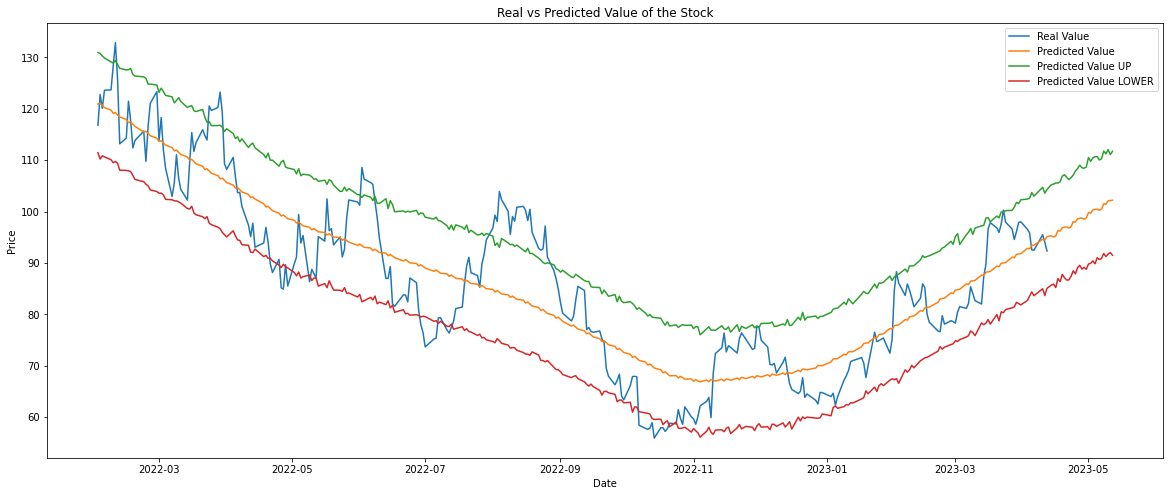

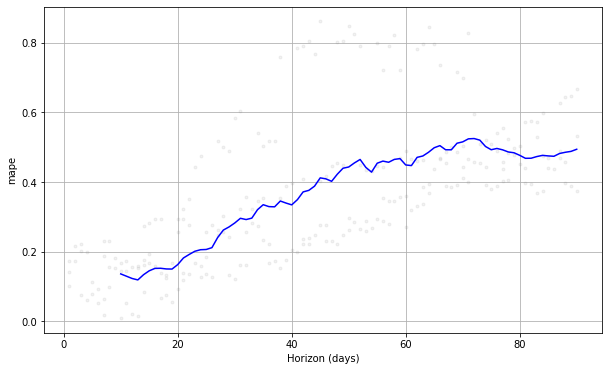

In [75]:
data = filter_df(amd, '2022-01-01', '2023-04-27')

prediction(data, 30)

>Observação: mudar o gráfico para o  plotly.express as px

In [71]:
# verificar o valor da ação hoje

today = datetime.date.today().strftime('%Y-%m-%d')
row = amd.loc[amd['Date'] == '2023-04-12']
row['Adj Close']

10858    92.330002
Name: Adj Close, dtype: float64


In [96]:
# prediction with px
def prediction_go(df, days: int):
    data = df[["Date", "Adj Close"]]
    data.ta.ema(close='Adj Close', length=21, append=True)
    data.dropna(inplace=True)

    # criando o dataset train
    df_train = data[["Date", "Adj Close", "EMA_21"]]
    df_train = df_train.rename(columns={"Date":"ds", "Adj Close":"y"})

    # fit model que iremos utilizar
    model = Prophet(daily_seasonality=True)

    # train model
    model.fit(df_train)

    n_days = days

    # create a date range
    future_dates = pd.date_range(start=df_train['ds'].max(), periods=n_days, freq=BDay())

    # create DF with the future dates
    future = pd.DataFrame({'ds': future_dates})

    # filter DF and keep week days
    future = future[future['ds'].dt.dayofweek < 5]

    future = model.make_future_dataframe(periods=30)

    predict = model.predict(future)

    # plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_train['ds'], y=df_train['y'], name='Real Value'))
    fig.add_trace(go.Scatter(x=predict['ds'], y=predict['yhat'], name='Predicted Value'))
    fig.add_trace(go.Scatter(x=predict['ds'], y=predict['yhat_upper'], name='Predicted Value UP'))
    fig.add_trace(go.Scatter(x=predict['ds'], y=predict['yhat_lower'], name='Predicted Value LOWER'))
    fig.update_layout(title='Real vs Predicted Value of the Stock',
                   xaxis_title='Date',
                   yaxis_title='Price')

    return fig.show()




In [97]:
data = filter_df(amd, '2022-01-01', '2023-04-27')

prediction_go(data, 30)

C:\Users\jeanm\AppData\Local\Temp\ipykernel_8664\2490050618.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jeanm\AppData\Local\Temp\ipykernel_8664\2490050618.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

11:51:47 - cmdstanpy - INFO - Chain [1] start processing
11:51:47 - cmdstanpy - INFO - Chain [1] done processing
